作業內容： 用tensorflow實作mnist的手寫數字分類

    在這次作業中，會用到tensorflow的一些基本套件，完成簡單的類神經網路
    手寫數字分類，是屬於classification的問題

首先要先仔入會用到的相關套件


In [59]:
# tensorflow & 載入 tensorflow 提供的 mnist 範例
import tensorflow as tf
import tensorflow.examples.tutorials.mnist.input_data as input_data
# 畫圖用
import matplotlib.pyplot as plt

dataset的部分直接載入tensorflow提供的mnist dataset

載入時，將one_hot設定為true，會自動把label的部分換成 one hot encoding 的形式

In [60]:
###################################################################################################################
## dataset
#載入 data
mnist_dataset = input_data.read_data_sets("MNIST_data/",one_hot=True)
print()

print('number of train', mnist_dataset.train.num_examples)
print('number of validation', mnist_dataset.validation.num_examples)
print('number of test',mnist_dataset.test.num_examples)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz

number of train 55000
number of validation 5000
number of test 10000


dataset中，每一張圖皆為一個手寫的數字，並且會有相對應的label

label為 0~9 共10個分類

在下面的例子中，可以看到在第8個label為1，代表此張圖的正確分類為7(label從0開始算)

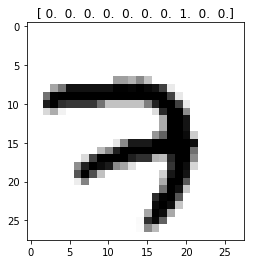

In [61]:
#畫一張 data 圖
plt.figure(1)
plt.title(mnist_dataset.train.labels[0])
plt.imshow(mnist_dataset.train.images[0].reshape(28,28),cmap='binary')
plt.show()

再來要開始建置簡單的類神經網路模型

先做一個簡單的函式用來宣告所有的layer

每個神經元最基本的運算為

f(x) = wx + b

w、b分別為炫戀時會調整的 weighting 和 bias

在函式中的前3行即為 weighting、bias 的宣告以及運算

函式的輸入參數分別包含了

    inputs_data : 輸入值
    input_dim : inputs_data 的 維度
    filter_Num : 此 layer 的神經元數量，也是此 layer 的 output 的維度
    activation : 要做的額外處理 (ex. relu)

宣告完這個函式後，就可以開始建立 model 本身

In [62]:
###################################################################################################################
## layer
# inputs_data : 輸入值
# input_dim : inputs_data 的 維度
# filter_Num : 此 layer 的神經元數量，也是此 layer 的 output 的維度
# activation : 要做的額外處理 (ex. relu)
def layer(inputs_data, input_dim, filter_Num, activation=None):
    weight = tf.Variable(tf.random_normal([input_dim,filter_Num]))
    bias = tf.Variable(tf.random_normal([1,filter_Num]))
    conv_func = tf.add(tf.matmul(inputs_data, weight),bias)
    if activation is None:
        return conv_func
    else:
        return activation(conv_func)

一開始先宣告兩個 placeholder 來放置 training data 的 input(圖片) 以及 output(label)

In [63]:
###################################################################################################################
## model的設定
# inout output設定
x = tf.placeholder("float",[None,784])#放 input img 的
y_GT = tf.placeholder("float",[None,10])#放 output label 的

再來宣告一個簡單的3層 hidden layer 架構

layer1的設定：

    輸入的資料為原始的圖片資料x
    輸入維度為圖片的大小784(28x28)
    在此層中，我設計給他128個神經元
    最結尾時多做一個relu的動作
    
layer2的設定：

    輸入的資料為上一層 layer1 的結果 output
    輸入維度承接了上一層結果的維度，為128
    越後面的hidden layer，習慣上會有更多的神經元，在此我設定為256
    最結尾時一樣做一個relu的動作
    
outputlayer的設定：

    輸入的資料為上一層 layer2 的結果 output
    輸入維度承接了上一層結果的維度，為256
    outputlayer的神經元數量需跟最後的label分類數量一致，所以為10
    outputlayer的結尾會直接接上softmax，若有relu會影響softmax的結果，所以這層不做設定

In [64]:
# 建立model
layer1 = layer(x,784,128,tf.nn.relu)
layer2 = layer(layer1,128,256,tf.nn.relu)
outputLayer = layer(layer2,256,10,None)

最後是定義 loss function 和宣告 optimizer 給 model 做 back propagation

loss function 部分，我比較了 model 產生的結果(outputLayer) 和實際資料的結果(y_GT) 的 softmax 差異，並希望差異越小越好

optimizer 部分則是設定 learning rate 以及 back propagation 用的 loss function

In [65]:
# 定義 loss function
loss_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=outputLayer, labels=y_GT))
# optimizer，會依照loss function的feed back去調整model中的filter值
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss_function)

後面加上一些計算 accuracy 的 function，可以院來畫成圖表

In [66]:
# 計算 accuracy
correct_prediction = tf.equal(tf.argmax(y_GT,1),tf.argmax(outputLayer,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,"float"))

做完 model 後，開始實際的 training 動作

首先要做一些training的設定，包含：

    epoch : dataset 總共要 train 幾次
    batch size: 一次 model 的更新要用幾筆資料
    session的宣告
    
然後宣告一些空陣列用來記錄以及最後畫圖表用

In [67]:
###################################################################################################################
## training
#基本設定
epoch = 10
batchSize = 128
batchPerEpoch = int(mnist_dataset.train.num_examples/batchSize)

# 設定session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

#空陣列，紀錄用
epoch_list = list()
for i in range(0, epoch):
    epoch_list.append(i)
loss_train_record=list()
acc_train_record=list()
loss_val_record=list()
acc_val_record=list()

開始用 for 迴圈，將 data 餵給 model 做training

在 for 迴圈中，會將 data 分成小 batch 餵到 model 中做 training

下面的程式碼中， sess.run(optimizer,feed_dict={x:batch_x,y_GT:batch_y}) 即為餵 data 更新 model 的動作

每跑完一次 epoch ，我會計算一次在 training data 及 validation data 的 loss 以及 accuracy

跑完所有 epoch 後畫出 training 狀況的曲線圖

Epoch[ 0 ]
	train  loss: 55.899 acc: 0.805418
	val    loss: 53.5201 acc: 0.8048
Epoch[ 1 ]
	train  loss: 31.3164 acc: 0.866291
	val    loss: 31.0762 acc: 0.8666
Epoch[ 2 ]
	train  loss: 21.6979 acc: 0.892055
	val    loss: 23.1288 acc: 0.8898
Epoch[ 3 ]
	train  loss: 16.1352 acc: 0.909982
	val    loss: 18.8975 acc: 0.9014
Epoch[ 4 ]
	train  loss: 12.4215 acc: 0.921691
	val    loss: 16.3074 acc: 0.9074
Epoch[ 5 ]
	train  loss: 9.92908 acc: 0.931291
	val    loss: 14.6245 acc: 0.913
Epoch[ 6 ]
	train  loss: 8.10918 acc: 0.938545
	val    loss: 13.3333 acc: 0.9186
Epoch[ 7 ]
	train  loss: 6.58713 acc: 0.945091
	val    loss: 12.4666 acc: 0.9234
Epoch[ 8 ]
	train  loss: 5.64813 acc: 0.948709
	val    loss: 11.9873 acc: 0.9268
Epoch[ 9 ]
	train  loss: 4.76333 acc: 0.952727
	val    loss: 11.2721 acc: 0.9266



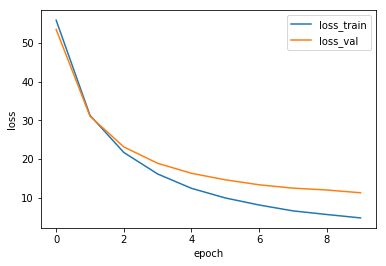

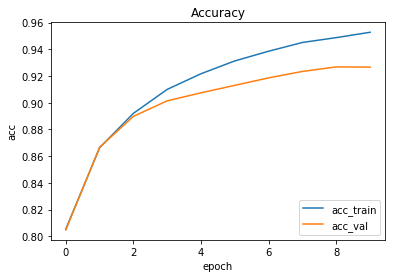

In [68]:
# 跑 epoch 做 training
for epoch in range(epoch):
    # for every batch
    for i in range(batchPerEpoch):#
        #batch_x, batch_y = mnist_dataset.train.next_batch(batchSize)
        batch_x =  mnist_dataset.train.images[i*batchSize:(i+1)*batchSize]
        batch_y =  mnist_dataset.train.labels[i*batchSize:(i+1)*batchSize]
        # training
        sess.run(optimizer,feed_dict={x:batch_x,y_GT:batch_y})
    # epoch 狀況    
    loss_train,acc_train = sess.run([loss_function,accuracy],feed_dict={x:mnist_dataset.train.images,y_GT:mnist_dataset.train.labels})
    loss_val,acc_val = sess.run([loss_function,accuracy],feed_dict={x:mnist_dataset.validation.images,y_GT:mnist_dataset.validation.labels})
    
    loss_train_record.append(loss_train)
    acc_train_record.append(acc_train)
    loss_val_record.append(loss_val)
    acc_val_record.append(acc_val)
    
    #print("Epoch[",epoch,"]  loss:",loss_val,"acc:",acc_val)
    print("Epoch[",epoch,"]")
    print("\ttrain  loss:",loss_train,"acc:",acc_train)
    print("\tval    loss:",loss_val,"acc:",acc_val)
print()

#畫 loss 圖
plt.figure(2)
plt.plot(epoch_list, loss_train_record, label='loss_train')
plt.plot(epoch_list, loss_val_record, label='loss_validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss_train','loss_val'],loc='upper right')
plt.show()

#畫 acc 圖
plt.figure(3)
plt.title("Accuracy")
plt.plot(epoch_list, acc_train_record, label='acc_train')
plt.plot(epoch_list, acc_val_record, label='acc_validation')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['acc_train','acc_val'],loc='lower right')
plt.show()

最後將 testing data 餵給 traini 好的 model，笧收最後的結果

In [69]:
###################################################################################################################
## testing
loss_test=list()
acc_test=list()

#testing
loss_test,acc_test = sess.run([loss_function,accuracy],feed_dict={x:mnist_dataset.test.images,y_GT:mnist_dataset.test.labels})

print("Testing sesult:")
print("\tTesting  loss:",loss_train,"acc:",acc_train)


Testing sesult:
	Testing  loss: 4.76333 acc: 0.952727
